# 使用数学优化进行共享单车系统再平衡

共享单车系统已经成为全球城市居民和游客日常通勤的有效方式。

作为最大的共享单车网络，纽约的 Citi-Bike 在2022年7月拥有1,588个活跃站点和25,575辆活跃单车。

2022年7月完成了超过300万次骑行，覆盖纽约市/霍博肯/泽西市，拥有约15万名活跃年度会员。

在高峰时段，许多自行车站点对单车有很高的需求，这意味着这些站点的单车流出量大于流入量。

同时，一些站点对停车位有很高的需求（骑行者将单车归还到这些站点），这意味着这些站点的单车流入量大于流出量。

高需求站点缺乏可用的单车或停车位会导致共享单车网络的严重不平衡，并造成客户不满和收入损失。

为了解决这个问题，需要在站点之间重新调配单车以平衡供需关系。

## 问题陈述和解决方案

使用2022年7月纽约和新泽西地区的Citi-bike历史数据，我们想要了解：
- 在8月第一周期间，每个站点每小时的单车需求是多少？
- 在知道需求的情况下，如何最小化销售损失？

销售损失是由于客户需要单车时却没有可用单车造成的。因此，应该将单车从流入量较高的站点转移到流出量较高的站点。

所以，首先需要确定每个站点在每个小时内应该增加或减少多少辆单车。然后，安排站点之间的实际单车转移。

在本笔记本中，我们将重点关注第一部分，并在最后讨论如何解决第二部分。
我们将结合机器学习(ML)和数学优化(MO)来解决这个问题。

**解决方案思路**
解决方案包含两个步骤：
- **第一步**：我们使用2022年7月纽约和新泽西地区的Citi-bike历史数据，使用ML模型预测8月第一周每个站点每小时的单车流入和流出量。本笔记本完成这一步骤。
- **第二步**：我们使用MO模型来决定每个站点在每个小时内应增加或减少多少单车，以最小化总销售损失。这在[bike_rebalancing](bike_rebalancing.ipynb)笔记本中完成。

为确保每个人都能使用gurobi受限许可运行笔记本，我们减少了数据规模。为此，我们将重点关注早高峰时段（上午7点到9点）的前50个站点。

使用PageRank算法选择热门站点。

# 导入包

In [1]:
import datetime
import io
import json
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from zipfile import ZipFile

# 收集、分析和创建所需数据

## Citi Bike 骑行历史数据

获取Citi Bike骑行数据:
- 访问[此链接](https://ride.citibikenyc.com/system-data)
- 点击 Citi Bike Trip Histories 下的链接
- 下载 "[202207-citbike-tripdata.csv.zip](https://s3.amazonaws.com/tripdata/202207-citbike-tripdata.csv.zip)" 和 "[JC-202207-citbike-tripdata.csv.zip](https://s3.amazonaws.com/tripdata/JC-202207-citbike-tripdata.csv.zip)"


[7月份Citi-Bike月度报告](https://mot-marketing-whitelabel-prod.s3.amazonaws.com/nyc/July-2022-Citi-Bike-Monthly-Report.pdf) 统计:

- 平均车队规模: 25,575辆单车
- 活跃站点: 1,588个
- 日均骑行次数: 109,305次 - 每辆单车每天使用4.13次


In [2]:
def download_zip_to_dataframe(url):
    response = requests.get(url)
    with ZipFile(io.BytesIO(response.content)) as zf:
        with zf.open(zf.namelist()[0]) as f:
            df = pd.read_csv(f, low_memory=False)
    return df

In [3]:
# 直接从url读取数据
# 纽约数据
nyc_citi_jul_2022 = download_zip_to_dataframe('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/optimization101/bike_share/202207-citbike-tripdata.csv.zip')
# 新泽西数据
jersey_citi_jul_2022 = download_zip_to_dataframe('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/optimization101/bike_share/JC-202207-citbike-tripdata.csv.zip')
citi_jul_network = pd.concat([nyc_citi_jul_2022, jersey_citi_jul_2022])
pd.isnull(citi_jul_network).sum()  # 统计每列的空值数量

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
start_station_id         0
end_station_name      3561
end_station_id        3561
start_lat                0
start_lng                0
end_lat               1851
end_lng               1851
member_casual            0
dtype: int64

In [5]:
# 存在少量终点站缺失数据，将其删除
citi_jul_network.dropna(inplace=True)
# 发现站点名称不一致的情况 'Broadway\t& W 48 St' 和 'Broadway\\t& W 48 St'
# 替换为 'Broadway & W 48 St' 使其保持一致
citi_jul_network['start_station_name'] = citi_jul_network['start_station_name'].replace(
    ['Broadway\t& W 48 St'], 'Broadway & W 48 St')
citi_jul_network['start_station_name'] = citi_jul_network['start_station_name'].replace(
    ['Broadway\\t& W 48 St'], 'Broadway & W 48 St')
citi_jul_network['end_station_name'] = citi_jul_network['end_station_name'].replace(
    ['Broadway\t& W 48 St'], 'Broadway & W 48 St')
citi_jul_network['end_station_name'] = citi_jul_network['end_station_name'].replace(
    ['Broadway\\t& W 48 St'], 'Broadway & W 48 St')

## 站点信息
Citi Bike发布的实时系统数据可以从[此链接](http://gbfs.citibikenyc.com/gbfs/gbfs.json)获取。

In [6]:
def get_stations_info():
    response_api = requests.get('https://gbfs.citibikenyc.com/gbfs/es/station_information.json')
    parse_json = json.loads(response_api.text)
    stations = parse_json['data']['stations']
    stations_dict = {}
    for station in stations:
        if 'region_id' in station:
            stations_dict[station['name']] = {'capacity': station['capacity'],
                                              'lat': station['lat'],
                                              'lon': station['lon'],
                                              'region': station['region_id']}
    if 'Broadway\t& W 48 St' in stations_dict:
        stations_dict['Broadway & W 48 St'] = stations_dict.pop('Broadway\t& W 48 St')  # 替换以匹配其他名称
    stations_info = pd.DataFrame(stations_dict).T
    # 删除容量为0的站点
    stations_info = stations_info.loc[stations_info.capacity > 0]
    return stations_info

In [7]:
stations_info = get_stations_info()
stations_info.head()

,capacity,lat,lon,region
23 Ave & 31 St,27,40.774233,-73.912749,71
Vesey St & Church St,78,40.71222,-74.010472,71
Myrtle Ave & 65 St,19,40.70117,-73.8904,71
E 138 St & 5 Ave,22,40.81449,-73.936153,71
44 St & Greenpoint Ave,27,40.74112,-73.921037,71


## 获取热门站点
使用PageRank算法获取热门站点

In [8]:
citi_df = citi_jul_network.groupby(['start_station_name', 'end_station_name'], 
                                   sort=False)['ride_id'].count().reset_index()
g = nx.from_pandas_edgelist(citi_df, source='start_station_name', target='end_station_name',
                            edge_attr='ride_id', create_using=nx.DiGraph)
wpr_scores_fwd = pd.Series(nx.pagerank(g, weight='ride_id')).sort_values(ascending=False)

Text(0, 0.5, 'PageRank Value')

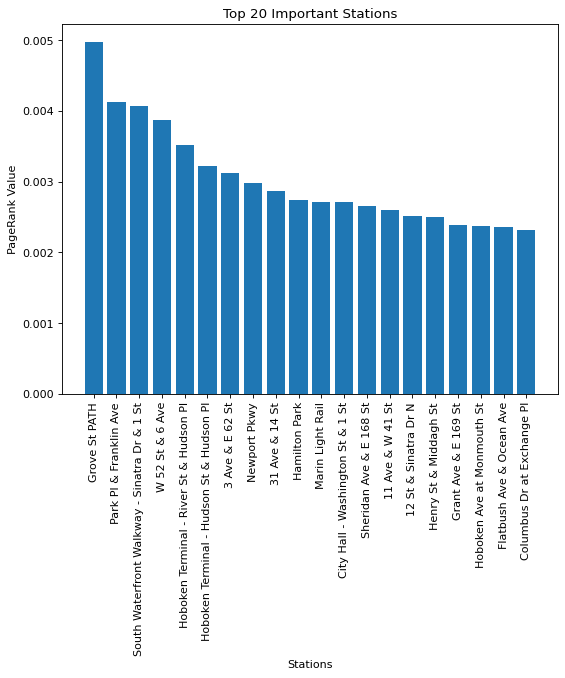

In [12]:
plt.figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=90)
plt.bar(wpr_scores_fwd.index[:20], wpr_scores_fwd.values[:20])
plt.title('Top 20 Important Stations')
plt.xlabel('Stations')
plt.ylabel('PageRank Value')

## 合并和过滤数据

In [13]:
# 根据网络重要性获取前N个站点
n = 50  # 用户可以定义选择多少个站点
top_stations = list(wpr_scores_fwd.head(n).index)
# 仅过滤出前N个站点的信息
top_stations_info = stations_info[stations_info.index.isin(top_stations)]
top_stations_info.shape  # 部分站点不在stations_info中

(44, 4)

In [15]:
# 实时站点数据和citi_jul_network中的站点存在差异
# 因此使用`top_station_info`中的站点值作为基准
top_stations = top_stations_info.index

In [16]:
# 开始
citi_jul_network_top = citi_jul_network[citi_jul_network['start_station_name'].isin(top_stations)]
citi_jul_network_top['started_at'] = pd.to_datetime(citi_jul_network_top['started_at']).dt.round('h')
citi_jul_2022_start = citi_jul_network_top.groupby(['start_station_name', 'started_at']).size().rename('start')
citi_jul_2022_start.head()

C:\Users\Jianhui Zhu\AppData\Local\Temp\ipykernel_38556\1833889823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citi_jul_network_top['started_at'] = pd.to_datetime(citi_jul_network_top['started_at']).dt.round('h')


start_station_name  started_at         
11 Ave & W 41 St    2022-07-01 00:00:00    2
                    2022-07-01 01:00:00    2
                    2022-07-01 02:00:00    2
                    2022-07-01 03:00:00    2
                    2022-07-01 06:00:00    2
Name: start, dtype: int64

In [17]:
# 结束
citi_jul_network_top = citi_jul_network[citi_jul_network['end_station_name'].isin(top_stations)]
citi_jul_network_top['ended_at'] = pd.to_datetime(citi_jul_network_top['ended_at']).dt.round('h')
citi_jul_2022_end = citi_jul_network_top.groupby(['end_station_name', 'ended_at']).size().rename('end')
citi_jul_2022_end.head()

C:\Users\Jianhui Zhu\AppData\Local\Temp\ipykernel_38556\1604340781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citi_jul_network_top['ended_at'] = pd.to_datetime(citi_jul_network_top['ended_at']).dt.round('h')


end_station_name  ended_at           
11 Ave & W 41 St  2022-07-01 00:00:00    6
                  2022-07-01 01:00:00    6
                  2022-07-01 02:00:00    1
                  2022-07-01 04:00:00    4
                  2022-07-01 05:00:00    1
Name: end, dtype: int64

In [18]:
# 合并每个站点的每小时骑行开始和结束数据
citi_jul_2022_hourly_combined = pd.concat(
    [citi_jul_2022_start, citi_jul_2022_end], axis=1).fillna(0).reset_index().rename(
    columns={'level_0': 'station', 'level_1': 'datetime'})
citi_jul_2022_hourly_combined.head()

,station,datetime,start,end
0,11 Ave & W 41 St,2022-07-01 00:00:00,2.0,6.0
1,11 Ave & W 41 St,2022-07-01 01:00:00,2.0,6.0
2,11 Ave & W 41 St,2022-07-01 02:00:00,2.0,1.0
3,11 Ave & W 41 St,2022-07-01 03:00:00,2.0,0.0
4,11 Ave & W 41 St,2022-07-01 06:00:00,2.0,0.0


In [19]:
# 清理并将数据保存为完整时间序列
data = citi_jul_2022_hourly_combined
data = data[data['datetime'].isin(pd.date_range(start='7/1/2022', end='7/31/2022 23:00:00', freq='H'))]
new_index = pd.MultiIndex.from_product([data.station.unique(), data.datetime.unique()])
clean_full_time_series = data.set_index(
    ['station', 'datetime']).reindex(new_index).fillna(0).reset_index().rename(
    columns={'level_0': 'station', 'level_1': 'datetime'})
clean_full_time_series.head()

C:\Users\Jianhui Zhu\AppData\Local\Temp\ipykernel_38556\2718263966.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data[data['datetime'].isin(pd.date_range(start='7/1/2022', end='7/31/2022 23:00:00', freq='H'))]


,station,datetime,start,end
0,11 Ave & W 41 St,2022-07-01 00:00:00,2.0,6.0
1,11 Ave & W 41 St,2022-07-01 01:00:00,2.0,6.0
2,11 Ave & W 41 St,2022-07-01 02:00:00,2.0,1.0
3,11 Ave & W 41 St,2022-07-01 03:00:00,2.0,0.0
4,11 Ave & W 41 St,2022-07-01 06:00:00,2.0,0.0


# Citi-Bike 2022年7月机器学习建模

## 创建主ML数据框
这需要同时为骑行的开始和结束数据执行

In [20]:
def prep_ml_df(col):
    """
    展平数据。时间序列不再按行排列，而是按列排列。
    获取上周和两周前的前12小时数据。

    预测未来一周。按小时计算 -> 168小时
    """
    mdf = clean_full_time_series[['station', 'datetime', col]].sort_values('datetime')
    ml_master_ls = []
    hours_prediction_horizon = 168  # 一周的小时数
    num_lagging_windows = hours_prediction_horizon + 12  # 时间x之前的12小时
    # 逐个处理每个ts_id的数据块
    for grp, df in mdf.groupby('station'):
        # 添加滞后需求数据
        for n in range(hours_prediction_horizon, num_lagging_windows + 1):
            df[f'{col}_lag_{n}'] = df[col].shift(n)  # 一周前
            df[f'{col}_lag_{n + 168}'] = df[col].shift(n + 168)  # 两周前
        ml_master_ls.append(df)
    # 将所有数据重新组合在一起
    ml_master_df = pd.concat(ml_master_ls, axis=0, ignore_index=True).dropna(axis=0)
    return ml_master_df, mdf

In [21]:
# 创建'start'的ML数据框
ml_master_df_start, master_df_start = prep_ml_df('start')
# 创建'end'的ML数据框
ml_master_df_end, master_df_end = prep_ml_df('end')

## 划分训练集和测试集

### 定义训练-测试集划分

In [26]:
def train_test_data(ml_df, start_end, train_test_cutoff):
    """将ml_df分为训练集和测试集
    
    我们保留训练和测试数据的键以便后续跟踪预测结果
    我们在下面的聚类代码之后创建数据
    注意：我们应该添加逻辑以确保从X_...数据集中删除了start
    """
    # 获取模型特征数据
    train_mask = ml_df.datetime < train_test_cutoff
    X_train = ml_df[train_mask].copy()
    X_test = ml_df[~train_mask].copy()

    # 获取模型目标
    y_train = X_train[start_end]
    y_test = X_test[start_end]

    # 删除未使用的列
    extra_cols = ['station', 'datetime', start_end]
    X_train.drop(extra_cols, axis=1, inplace=True)
    X_test.drop(extra_cols, axis=1, inplace=True)
    return X_train, y_train, X_test, y_test

In [27]:
cutoff_time = datetime.datetime(year=2022, month=7, day=27)
# Start
X_train_start, y_train_start, X_test_start, y_test_start = train_test_data(ml_master_df_start, 'start', cutoff_time)
# End
X_train_end, y_train_end, X_test_end, y_test_end = train_test_data(ml_master_df_end, 'end', cutoff_time)

## 运行ML模型和测试

In [28]:
def create_ml_models(x_train, y_train, x_test, y_test):
    best_model = None
    best_model_name = None
    best_score = 0
    for name, regression in zip(['xgb', 'svm', 'linear regression'],
                                [XGBRegressor, LinearSVR, LinearRegression]):
        ml_model = regression()
        ml_model.fit(x_train, y_train)
        print(f'{name} results\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        score = r2_score(y_test, ml_model.predict(x_test))
        print(score)
        if score > best_score:
            best_score = score
            best_model = ml_model
            best_model_name = name
    print(f'\nBest model: {best_model_name}\n')
    return best_model

In [29]:
# Start
ml_model_start = create_ml_models(X_train_start, y_train_start, X_test_start, y_test_start)
# End
ml_model_end = create_ml_models(X_train_end, y_train_end, X_test_end, y_test_end)

xgb results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.552256012128425


d:\ComputerSoftware\Python\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\ComputerSoftware\Python\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ComputerSoftware\Python\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


svm results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.5699795834089112
linear regression results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.6034301888320571

Best model: linear regression

xgb results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.5374559468326788
svm results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.3892745753232735
linear regression results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.5776995169694515

Best model: linear regression



d:\ComputerSoftware\Python\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## 进行预测

In [30]:
def create_prediction_df(master_df, ml_model, col):
    ml_master_ls = []
    hours_prediction_horizon = 168  # 一周的小时数
    num_lagging_windows = hours_prediction_horizon + 12  # 时间x之前的12小时
    # 逐个处理每个ts_id的数据块
    date_range = pd.date_range(start='8/1/2022', end='8/5/2022 23:00:00', freq='H')
    for grp, df in master_df.groupby('station'):
        prediction_df = pd.DataFrame({'station': grp, col: 0, 'datetime': date_range})
        df = pd.concat([df, prediction_df], axis=0, ignore_index=True)
        # 确保排序
        df.sort_values('datetime', inplace=True)
        # 添加滞后需求数据
        for n in range(hours_prediction_horizon, num_lagging_windows + 1):
            df[f'{col}_lag_{n}'] = df[col].shift(n)  # 一周前
            df[f'{col}_lag_{n + 168}'] = df[col].shift(n + 168)  # 两周前
        ml_master_ls.append(df)
    # 将所有数据重新组合在一起
    ml_master_df = pd.concat(ml_master_ls, axis=0, ignore_index=True)
    prediction_master = ml_master_df[ml_master_df['datetime'].isin(date_range)]
    prediction_ml = prediction_master.drop(['station', 'datetime', col], axis=1)  # 模型数据框
    # 数据框预测键作为预测结果的占位符
    prediction_key = prediction_master[['station', 'datetime']].copy()
    prediction_key[f'{col}_forecast'] = ml_model.predict(prediction_ml)
    return prediction_key

In [31]:
# 八月第一周，周一至周五的预测
# 创建'start'的预测数据框
start_prediction_key = create_prediction_df(master_df_start, ml_model_start, 'start')
# 创建'end'的预测数据框
end_prediction_key = create_prediction_df(master_df_end, ml_model_end, 'end')
predictions_final = pd.merge(start_prediction_key, end_prediction_key, on=['station', 'datetime'])
top_stations_info.to_csv('top_stations.csv', index_label='station')
predictions_final.round(0).to_csv('stations_flow.csv', index=False)

C:\Users\Jianhui Zhu\AppData\Local\Temp\ipykernel_38556\4006967382.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='8/1/2022', end='8/5/2022 23:00:00', freq='H')
C:\Users\Jianhui Zhu\AppData\Local\Temp\ipykernel_38556\4006967382.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='8/1/2022', end='8/5/2022 23:00:00', freq='H')
